In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error, mean_absolute_error
plt.style.use('fivethirtyeight')
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.inspection import permutation_importance
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
import talib as ta

import psycopg2
from configparser import ConfigParser
plt.style.use('fivethirtyeight')

print ('import completed')

import completed


In [53]:
# Enter in how much steps we will enroll the network.
# RNN/LSTM/GRU can be taught patterns over times series as big as the number of times you enrol them, and no bigger (fundamental limitation). 
# So by design these networks are deep/long to catch recurrent patterns.
#timesteps per samples
Enrol_window = 1

print ('enrol window set to',Enrol_window )

enrol window set to 1


In [54]:
# Support functions
scaler = MinMaxScaler(feature_range=(0,1))
scaler_y = MinMaxScaler(feature_range=(0,1))
std_scaler = StandardScaler()


# for multivariate, nth timesteps output is used for n timesteps input so first output before nth is not used (Multiple Input Series)
def split_multi(sequences, n_steps):
    sequences = sequences.to_numpy()
#     print(sequences)
    
    X, y = [], []
    for i in range(len(sequences)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the dataset
        if end_ix > len(sequences)-1:
            break
        # gather input and output parts of the pattern
        X.append(sequences[i:end_ix, :-1])
        y.append(sequences[end_ix, -1])
        
    return np.array(X), np.array(y)

def split_multi_output(sequences, n_steps_in, n_steps_out):
    sequences = sequences.to_numpy()
#     print(sequences)
    
    X, y = [], []
    for i in range(len(sequences)):
        # find the end of this pattern
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out
        # check if we are beyond the dataset
        if out_end_ix > len(sequences):
            break
        # gather input and output parts of the pattern
        X.append(sequences[i:end_ix, :-1])
        y.append(sequences[end_ix:out_end_ix, -1])
        
    return np.array(X), np.array(y)
                           
#for univariate(1 feature)
def split_uni(sequences, n_steps,normalise_window):
    sequence_length = n_steps + 1
    result = []
    for index in range(len(sequences) - sequence_length):
        result.append(sequences[index: index + sequence_length])
    
    if normalise_window:
        #result = sc.fit_transform(result)
        result = normalise_windows(result)

    return np.array(result)
                           
def load_data(datasetname, column, seq_len, normalise_window, n_outputs):
    # A support function to help prepare datasets for an RNN/LSTM/GRU
    data = datasetname.loc[:,column]
    
    row = round(0.6 * data.shape[0])
    
    if normalise_window:
#         data = std_scaler.fit_transform(data)
        data = scaler.fit_transform(data)
    
    data = pd.DataFrame(data,columns = column)
    
    data_train = data[:int(row)]
    data_test = data[int(row):]
    
#     if normalise_window:
#         data_train = std_scaler.fit_transform(data_train)
#         data_test = std_scaler.transform(data_test)
        
#         data_train = scaler.fit_transform(data_train)
#         data_test = scaler.transform(data_test)
#           data_train = scaler.fit_transform(data_train)
#         data_test = scaler.transform(data_test)
# scaler_y = MinMaxScaler(feature_range=(0,1))
        
    
#     data = pd.DataFrame(data,columns = column)
#     data_test = pd.DataFrame(data_test,columns = data.columns)
    
    print(data.describe())
    
    x_train, y_train = split_multi_output(data_train, seq_len, n_outputs)
    x_test, y_test = split_multi_output(data_test, seq_len, n_outputs)
    
#     y_train =to_categorical(y_train)
#     y_test =to_categorical(y_test)
    print(y_train)
    
    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], x_train.shape[2]))
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], x_test.shape[2]))

    return [x_train, y_train, x_test, y_test]

def normalise_windows(window_data):
    # A support function to normalize a dataset
    normalised_data = []
    for window in window_data:
        normalised_window = [((float(p) / float(window[0])) - 1) for p in window]
        normalised_data.append(normalised_window)
    return normalised_data

def predict_sequence_full(model, data, window_size):
    #Shift the window by 1 new prediction each time, re-run predictions on new window
    curr_frame = data[0]
    predicted = []
    for i in range(len(data)):
        predicted.append(model.predict(curr_frame[newaxis,:,:])[0,0])
        curr_frame = curr_frame[1:]
        curr_frame = np.insert(curr_frame, [window_size-1], predicted[-1], axis=0)
    return predicted

def predict_sequences_multiple(model, data, window_size, prediction_len):
    #Predict sequence of <prediction_len> steps before shifting prediction run forward by <prediction_len> steps
    prediction_seqs = []
    for i in range(int(len(data)/prediction_len)):
        curr_frame = data[i*prediction_len]
        predicted = []
        for j in range(prediction_len):
            predicted.append(model.predict(curr_frame[newaxis,:,:])[0,0])
            curr_frame = curr_frame[1:]
            curr_frame = np.insert(curr_frame, [window_size-1], predicted[-1], axis=0)
        prediction_seqs.append(predicted)
    return prediction_seqs

def plot_results(predicted_data, true_data): 
    fig = plt.figure(facecolor='white', figsize = (12,12)) 
    ax = fig.add_subplot(111) 
    ax.plot(true_data, label='True Data') 
    ax2 = ax.twinx()  # instantiate a second axes that shares the same x-axis

    ax2.plot(predicted_data, label='Prediction', color ='red') 
    plt.legend() 
    plt.show() 

def plot_result(predicted_data): 
    fig = plt.figure(facecolor='white') 
    ax = fig.add_subplot(111) 
    plt.plot(predicted_data, label='Prediction') 
    plt.legend() 
    plt.show() 
    
def plot_results_multiple(predicted_data, true_data, prediction_len):
    fig = plt.figure(facecolor='white')
    ax = fig.add_subplot(111)
    ax.plot(true_data, label='True Data')
    #Pad the list of predictions to shift it in the graph to it's correct start
    for i, data in enumerate(predicted_data):
        padding = [None for p in range(i * prediction_len)]
        plt.plot(padding + data, label='Prediction')
        plt.legend()
    plt.show()

print ('Support functions defined')

Support functions defined


In [17]:
lq45 = ['ACES','ADRO','AKRA','ANTM','ASII',
            'BBCA','BBNI','BBRI','BBTN','BMRI',
            'BSDE','BTPS','CPIN','CTRA','ERAA',
            'EXCL','GGRM','HMSP','ICBP','INCO',
            'INDF','INKP','INTP','ITMG','JPFA',
            'JSMR','KLBF','MDKA','MIKA','MNCN',
            'PGAS','PTBA','PTPP','PWON','SCMA',
            'SMGR','SMRA','SRIL','TBIG','TKIM',
            'TLKM','TOWR','UNTR','UNVR','WIKA'
       ]

kompas100 = 'AALI,ACES,ADHI,ADRO,AKRA,ANTM,APLN,ASII,ASSA,BBCA,BBKP,BBNI,BBRI,BBTN,BDMN,BEST,BJBR,BJTM,BMRI,BMTR,BNLI,BRIS,BRPT,BSDE,BTPS,BULL,CLEO,CPIN,CTRA,DMAS,ELSA,ERAA,EXCL,GGRM,GIAA,HKMU,HMSP,HOKI,ICBP,INAF,INCO,INDF,INDY,INKP,INTP,ISAT,ITMG,JPFA,JRPT,JSMR,KAEF,KBLI,KINO,KLBF,LINK,LPKR,LPPF,LSIP,MAIN,MAPI,MDKA,MEDC,MIKA,MNCN,MTDL,MYOR,PGAS,PNBN,PNLF,PSAB,PTBA,PTPP,PWON,RALS,SCMA,SIDO,SILO,SIMP,SMBR,SMGR,SMRA,SMSM,SPTO,SRIL,SSIA,SSMS,TBIG,TINS,TKIM,TLKM,TOWR,TPIA,UNTR,UNVR,WEGE,WIKA,WOOD,WSBP,WSKT,WTON'
kompas100 = kompas100.split(',')

def config(filename="D:\python\database.ini", section='postgresql'):
    # create a parser
    parser = ConfigParser()
    # read config file
    parser.read(filename)

    # get section, default to postgresql
    db = {}
    if parser.has_section(section):
        params = parser.items(section)
        for param in params:
            db[param[0]] = param[1]
    else:
        raise Exception('Section {0} not found in the {1} file'.format(section, filename))

    return db

def get_stocks_data(date):
    """ query tickers from the idxstocks table """
    conn = None
    stocks_df = None
    try:
        params = config()
        conn = psycopg2.connect(**params)
#         sql="SELECT date, stock, close, volume, foreign_buy, foreign_sell FROM idxstocks WHERE date >= %s::Date"
        sql="SELECT date, stock, close, high, low, open, volume FROM stocks WHERE date >= %s::Date"
        
        stocks_df = pd.read_sql(sql,conn, None, params=[date])
        print("The number of dates: ", len(stocks_df.index.unique()))

    except (Exception, psycopg2.DatabaseError) as error:
        print(error)
    finally:
        if conn is not None:
            conn.close()
    return stocks_df

def get_broksum_data(date):
    conn = None
    broksum_df = None
    try:
        params = config()
        conn = psycopg2.connect(**params)
        sql="SELECT * FROM brokersummary WHERE date >= %s::Date"
        broksum_df = pd.read_sql(sql,conn, None, params=[date])
        print("The number of dates: ", len(broksum_df.index.unique()))

    except (Exception, psycopg2.DatabaseError) as error:
        print(error)
    finally:
        if conn is not None:
            conn.close()
    return broksum_df


today = '2020-12-18'
date = "2021-01-01"
all_stocks_df = get_stocks_data(date)
all_stocks_df['date'] = pd.to_datetime(all_stocks_df['date'])
all_stocks_df = all_stocks_df.set_index('date').sort_index()
broksum_df = get_broksum_data(date)
broksum_df['date'] = pd.to_datetime(broksum_df['date'])
broksum_df = broksum_df.set_index('date').sort_index()

The number of dates:  98997
The number of dates:  3660363


In [6]:
my_stock = ['MDKA','TINS','JPFA','PZZA','ASII','NATO']
check =['MLPL']
selected_stocks = check

In [66]:

# print(broksum_df)
broksum_selected = broksum_df[broksum_df.stock.isin(selected_stocks)]
broksum_selected['buy'] = broksum_selected['buy'].replace({True: 1, False: 0})
broksum_selected['volume'] = broksum_selected['volume']*100

# print(broksum_selected)
broksum_pivot = pd.pivot_table(broksum_selected, index=[broksum_selected.index,'stock'], columns=['buy','broker']).fillna(0)
# print(broksum_pivot.columns)
# print(broksum_selected[broksum_selected.index=='2020-01-02'].sort_values(by=['broker','buy']))
# print(broksum_pivot['volume'])
# print(broksum_pivot.columns)
diff = broksum_pivot[('volume',1)]-broksum_pivot[('volume',0)]
diff.columns = pd.MultiIndex.from_tuples([('volume', 'net', col) for col in diff.columns])
# print(diff)
broksum_pivot = pd.concat([broksum_pivot, diff],axis =1)
broksum_pivot = broksum_pivot.reset_index(level='stock')
# print(broksum_pivot)
# print(broksum_pivot.columns)

broksum_vol_net = broksum_pivot[('volume','net')]
binary_broksum_vol_net = broksum_vol_net.applymap(lambda x: 1 if x>0 else 0)
#     print(broksum_vol_net.columns.values)
# broksum_vol_cumsum = broksum_vol_net.cumsum()
# print(broksum_vol_cumsum.columns)
print(broksum_vol_net)
print(binary_broksum_vol_net)


stock_df_selected = all_stocks_df[all_stocks_df.stock.isin(selected_stocks)]
stock_df = stock_df_selected.iloc[:len(binary_broksum_vol_net)]
# broksum_vol_cumsum.loc[stock_df['close']-stock_df['close'].shift(1) <= 0, 'out'] = 0 
# broksum_vol_cumsum.loc[stock_df['close']-stock_df['close'].shift(1)  > 0, 'out'] = 1

# broksum_vol_cumsum['label'] = stock_df['close']
# broksum_vol_cumsum = broksum_vol_cumsum.dropna(1)
# broksum_vol_cumsum = broksum_vol_cumsum.fillna(0)

# print(broksum_vol_net)

broker            AF        AG   AH         AI         AK        AN  \
date                                                                  
2021-01-04       0.0       0.0  0.0    -2700.0        0.0       0.0   
2021-01-05       0.0       0.0  0.0        0.0        0.0       0.0   
2021-01-06       0.0    2200.0  0.0 -1372000.0        0.0       0.0   
2021-01-07       0.0       0.0  0.0        0.0        0.0       0.0   
2021-01-08       0.0    2000.0  0.0        0.0        0.0       0.0   
...              ...       ...  ...        ...        ...       ...   
2021-07-16       0.0  -25900.0  0.0   149900.0 -2814400.0  250000.0   
2021-07-19   20000.0  -87900.0  0.0     8200.0 -1508800.0   30000.0   
2021-07-21 -200000.0 -139000.0  0.0 -7590100.0  2316000.0  300000.0   
2021-07-22  200000.0  -53100.0  0.0 -1945800.0  -888400.0  750500.0   
2021-07-23   20000.0   85900.0  0.0 -1978500.0 -1397500.0   10000.0   

broker             AO       AR         AT         AZ  ...         XA  \
date

C:\Users\kriz_\anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\kriz_\anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
C:\Users\kriz_\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2878: PerformanceWarning: indexing past lexsort depth may impact performance.
  raw_cell, 

           stock  close  high  low  open     volume
date                                               
2021-01-04  MLPL     70    72   69    70    5991700
2021-01-05  MLPL     70    75   70    70   25788900
2021-01-06  MLPL     70    71   69    70    4493100
2021-01-07  MLPL     70    71   70    70    7361100
2021-01-08  MLPL     69    71   67    70    9925500
...          ...    ...   ...  ...   ...        ...
2021-07-16  MLPL    675   690  660   690   65505700
2021-07-19  MLPL    655   685  630   675  188766800
2021-07-21  MLPL    685   700  640   660  208603400
2021-07-22  MLPL    670   695  650   685   90918700
2021-07-23  MLPL    640   675  640   670   64640200

[136 rows x 6 columns]
            out
date           
2021-01-04    0
2021-01-05    0
2021-01-06    0
2021-01-07    0
2021-01-08    0
...         ...
2021-07-16    0
2021-07-19    0
2021-07-21    1
2021-07-22    0
2021-07-23    0

[136 rows x 1 columns]
             AF   AG   AH   AI   AK   AN   AO   AR   AT   AZ  ...   

,AF,AG,AH,AI,AK,AN,AO,AR,AT,AZ,...,XC,XL,YB,YJ,YO,YP,YU,ZP,ZR,out
date,,,,,,,,,,,,,,,,,,,,,
2021-01-04,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0
2021-01-05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0
2021-01-06,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0
2021-01-07,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0
2021-01-08,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-07-16,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,...,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0
2021-07-19,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0
2021-07-21,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1


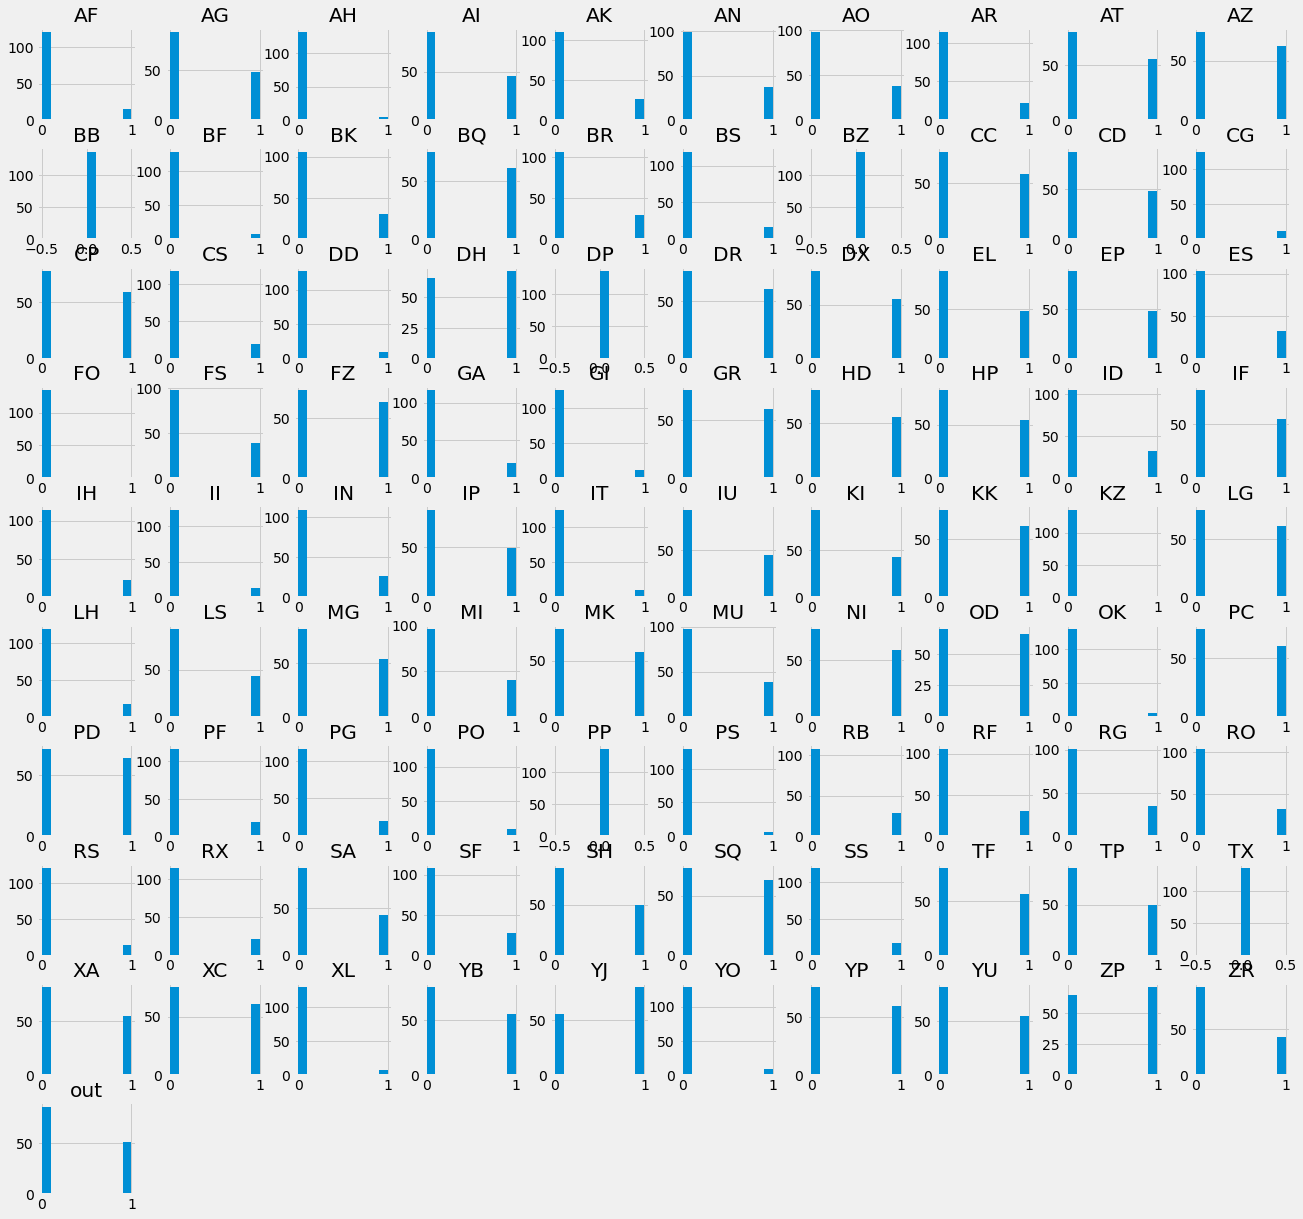

In [26]:
# selected_stocks = ['BBRI']

# broksum_selected = broksum_df[broksum_df.stock.isin(selected_stocks)]
# broksum_selected['buy'] = broksum_selected['buy'].replace({True: 1, False: 0})
# broksum_selected['volume'] = broksum_selected['volume']*100

# # print(broksum_selected)
# broksum_pivot = pd.pivot_table(broksum_selected, index=[broksum_selected.index], columns=['broker','buy']).fillna(0)
# print(broksum_pivot)
stock_df_selected = all_stocks_df[all_stocks_df.stock.isin(selected_stocks)]
print(stock_df_selected)
binary_stock_df = pd.DataFrame(np.where(stock_df_selected.close > stock_df_selected.open,1,0),index = stock_df_selected.index,columns =['out'])
print(binary_stock_df)
# stock_df_selected = pd.concat([stock_df_selected, broksum_pivot],axis =1)
stock_df_selected = pd.concat([binary_broksum_vol_net, binary_stock_df],axis =1)

# print(stock_df_selected.columns)

print(stock_df_selected)
# stock_df_selected['date'] = stock_df_selected.index
# # stock_df_selected['dayofweek'] = stock_df_selected['date'].dt.dayofweek
# # stock_df_selected['quarter'] = stock_df_selected['date'].dt.quarter
# # stock_df_selected['month'] = stock_df_selected['date'].dt.month
# # # stock_df_selected['year'] = stock_df_selected['date'].dt.year
# # stock_df_selected['dayofyear'] = stock_df_selected['date'].dt.dayofyear
# stock_df_selected['dayofmonth'] = stock_df_selected['date'].dt.day
# # stock_df_selected['weekofyear'] = stock_df_selected['date'].dt.weekofyear

# # stock_df_selected['EMA5'] = ta.EMA(stock_df_selected['close'], timeperiod=5)
# # stock_df_selected['EMA10'] = ta.EMA(stock_df_selected['close'], timeperiod=10)
# # stock_df_selected['EMA15'] = ta.EMA(stock_df_selected['close'], timeperiod=15)
# # stock_df_selected['EMA20'] = ta.EMA(stock_df_selected['close'], timeperiod=10)
# # stock_df_selected['EMA30'] = ta.EMA(stock_df_selected['close'], timeperiod=30)
# # stock_df_selected['EMA40'] = ta.EMA(stock_df_selected['close'], timeperiod=40)
# # stock_df_selected['EMA50'] = ta.EMA(stock_df_selected['close'], timeperiod=50)

# # stock_df_selected['EMA60'] = ta.EMA(stock_df_selected['close'], timeperiod=60)
# # stock_df_selected['EMA70'] = ta.EMA(stock_df_selected['close'], timeperiod=70)
# # stock_df_selected['EMA80'] = ta.EMA(stock_df_selected['close'], timeperiod=80)
# # stock_df_selected['EMA90'] = ta.EMA(stock_df_selected['close'], timeperiod=90)

# # stock_df_selected['EMA100'] = ta.EMA(stock_df_selected['close'], timeperiod=100)
# # stock_df_selected['EMA150'] = ta.EMA(stock_df_selected['close'], timeperiod=150)
# # stock_df_selected['EMA200'] = ta.EMA(stock_df_selected['close'], timeperiod=200)

# stock_df_selected['upperBB'], stock_df_selected['middleBB'], stock_df_selected['lowerBB'] = ta.BBANDS(stock_df_selected['close'], timeperiod=20, nbdevup=2, nbdevdn=2, matype=0)

# stock_df_selected['SAR'] = ta.SAR(stock_df_selected['high'], stock_df_selected['low'], acceleration=0.02, maximum=0.2)

# stock_df_selected['RSI'] = ta.RSI(stock_df_selected['close'], timeperiod=14)

# # stock_df_selected['aboveEMA5'] = np.where(stock_df_selected['close'] > stock_df_selected['EMA5'], 1, -1)
# # stock_df_selected['aboveEMA10'] = np.where(stock_df_selected['close'] > stock_df_selected['EMA10'], 1, -1)
# # stock_df_selected['aboveEMA15'] = np.where(stock_df_selected['close'] > stock_df_selected['EMA15'], 1, -1)
# # stock_df_selected['aboveEMA20'] = np.where(stock_df_selected['close'] > stock_df_selected['EMA20'], 1, -1)
# # stock_df_selected['aboveEMA30'] = np.where(stock_df_selected['close'] > stock_df_selected['EMA30'], 1, -1)
# # stock_df_selected['aboveEMA40'] = np.where(stock_df_selected['close'] > stock_df_selected['EMA40'], 1, -1)

# # stock_df_selected['aboveEMA50'] = np.where(stock_df_selected['close'] > stock_df_selected['EMA50'], 1, -1)
# # stock_df_selected['aboveEMA60'] = np.where(stock_df_selected['close'] > stock_df_selected['EMA60'], 1, -1)
# # stock_df_selected['aboveEMA70'] = np.where(stock_df_selected['close'] > stock_df_selected['EMA70'], 1, -1)
# # stock_df_selected['aboveEMA80'] = np.where(stock_df_selected['close'] > stock_df_selected['EMA80'], 1, -1)
# # stock_df_selected['aboveEMA90'] = np.where(stock_df_selected['close'] > stock_df_selected['EMA90'], 1, -1)

# # stock_df_selected['aboveEMA100'] = np.where(stock_df_selected['close'] > stock_df_selected['EMA100'], 1, -1)
# # stock_df_selected['aboveEMA150'] = np.where(stock_df_selected['close'] > stock_df_selected['EMA150'], 1, -1)
# # stock_df_selected['aboveEMA200'] = np.where(stock_df_selected['close'] > stock_df_selected['EMA200'], 1, -1)

# # stock_df_selected['aboveUpperBB'] = np.where(stock_df_selected['close'] > stock_df_selected['upperBB'], 1, -1)
# # stock_df_selected['belowlowerBB'] = np.where(stock_df_selected['close'] < stock_df_selected['lowerBB'], 1, -1)

# # stock_df_selected['aboveSAR'] = np.where(stock_df_selected['close'] > stock_df_selected['SAR'], 1, -1)

# # stock_df_selected['oversoldRSI'] = np.where(stock_df_selected['RSI'] < 30, 1, -1)
# # stock_df_selected['overboughtRSI'] = np.where(stock_df_selected['RSI'] > 70, 1, -1)


# stock_df_selected['nbsa'] = stock_df_selected['foreign_buy']-stock_df_selected['foreign_sell']
# stock_df_selected['nbsa_cumsum'] = stock_df_selected['nbsa'].cumsum()
# stock_df_selected['fn_vol'] = (stock_df_selected['foreign_buy']+stock_df_selected['foreign_sell'])/2
# # stock_df_selected['fn_buy_part'] = stock_df_selected['foreign_buy']/(2*stock_df_selected['fn_vol'])
# # stock_df_selected['fn_sell_part'] = stock_df_selected['foreign_sell']/(2*stock_df_selected['fn_vol'])
# # stock_df_selected['log_nbsa'] = np.log(stock_df_selected['foreign_buy'])-np.log(stock_df_selected['foreign_sell'])

# stock_df_selected['fn_part'] = stock_df_selected['fn_vol']/stock_df_selected['volume']
# stock_df_selected['fn_net_str'] = abs(stock_df_selected['nbsa'])/(stock_df_selected['fn_vol']*2)

# # stock_df_selected.hist(figsize=(20,20))

# stock_df_selected['log_prev'] = np.log(stock_df_selected.prev)
# stock_df_selected['log_low'] = np.log(stock_df_selected.low)
# stock_df_selected['log_high'] = np.log(stock_df_selected.high)
# # stock_df_selected['close'] = np.log(stock_df_selected.close)
# stock_df_selected['log_close'] = np.log(stock_df_selected.close)
# # stock_df_selected['volume'] = np.log(stock_df_selected.volume+1)
# # stock_df_selected['value'] = np.log(stock_df_selected.value+1)
# # stock_df_selected['freq'] = np.log(stock_df_selected.freq)
# # stock_df_selected['offer'] = stock_df_selected.offer
# # stock_df_selected['bid'] = np.log(stock_df_selected.bid+1)
# # stock_df_selected['offer_volume'] = np.log(stock_df_selected.offer_volume+1)
# # stock_df_selected['bid_volume'] = np.log(stock_df_selected.bid_volume+1)
# # stock_df_selected['nbsa_cumsum'] = stock_df_selected.nbsa_cumsum-min(stock_df_selected.nbsa_cumsum)
# # stock_df_selected[['nbsa_cumsum']] = scaler.fit_transform(stock_df_selected[['nbsa_cumsum']])
# # stock_df_selected['fn_vol'] = np.log(stock_df_selected.fn_vol+1)
# # stock_df_selected['fn_net_str'] = np.log(stock_df_selected.fn_net_str+1)

# stock_df_selected['log_ret_close'] = stock_df_selected.log_close-stock_df_selected.log_close.shift(1)
# stock_df_selected['log_ret_high'] = stock_df_selected.log_high-stock_df_selected.log_high.shift(1)
# stock_df_selected['log_ret_low'] = stock_df_selected.log_low-stock_df_selected.log_low.shift(1)
# stock_df_selected['log_ret_prev'] = stock_df_selected.log_prev-stock_df_selected.log_prev.shift(1)

# stock_df_selected.loc[stock_df_selected['log_ret_close'] == 0, 'out'] = 0 
# stock_df_selected.loc[stock_df_selected['log_ret_close'] > 0, 'out'] = 1
# stock_df_selected.loc[stock_df_selected['log_ret_close'] < 0, 'out'] = -1

# stock_df_selected['label'] = stock_df_selected['out']
# # stock_df_selected['label'] = to_categorical(stock_df_selected['label'])

# stock_df_selected = stock_df_selected.drop(columns=['date','stock', 'high','low', 'prev', 'close', 'log_low',
#                                                      'offer', 'offer_volume', 'bid', 'bid_volume',
#                                                     'log_high','change','weight_for_index','listed_shares','tradable_shares',
#                                                     'stock_name','remarks','index_individual','non_regular_volume',
#                                                     'non_regular_value', 'non_regular_freq','open_price','first_trade'])

stock_df_selected = stock_df_selected.fillna(0)

# stock_df_selected = pd.DataFrame(normalize(stock_df_selected, axis=-1, order=2))



stock_df_selected.hist(figsize=(20,20))

# print(stock_df_selected.nbsa_cumsum)
# stock_df_selected.describe()
display(stock_df_selected)

In [27]:
print(stock_df_selected.columns)

Index(['AF', 'AG', 'AH', 'AI', 'AK', 'AN', 'AO', 'AR', 'AT', 'AZ', 'BB', 'BF',
       'BK', 'BQ', 'BR', 'BS', 'BZ', 'CC', 'CD', 'CG', 'CP', 'CS', 'DD', 'DH',
       'DP', 'DR', 'DX', 'EL', 'EP', 'ES', 'FO', 'FS', 'FZ', 'GA', 'GI', 'GR',
       'HD', 'HP', 'ID', 'IF', 'IH', 'II', 'IN', 'IP', 'IT', 'IU', 'KI', 'KK',
       'KZ', 'LG', 'LH', 'LS', 'MG', 'MI', 'MK', 'MU', 'NI', 'OD', 'OK', 'PC',
       'PD', 'PF', 'PG', 'PO', 'PP', 'PS', 'RB', 'RF', 'RG', 'RO', 'RS', 'RX',
       'SA', 'SF', 'SH', 'SQ', 'SS', 'TF', 'TP', 'TX', 'XA', 'XC', 'XL', 'YB',
       'YJ', 'YO', 'YP', 'YU', 'ZP', 'ZR', 'out'],
      dtype='object')


In [55]:
# Prepare the dataset, note that the stock price data will be normalized between 0 and 1
# A label is the thing we're predicting
# A feature is an input variable

# print(stock_df_selected['log_ret'])
n_outputs=1
feature_train, label_train, feature_test, label_test = load_data(stock_df_selected, stock_df_selected.columns, Enrol_window, False, n_outputs)
print(feature_test)
print(feature_test.shape)
print(label_test)
# feature_train.describe()
# stock_df_selected["log_ret"][:'2019'].plot(figsize=(16,4),legend=True)
# stock_df_selected["log_ret"]['2020':].plot(figsize=(16,4),legend=True) # 10% is used for thraining data which is approx 2017 data
# plt.legend(['Training set (First 90%, approx before 2017)','Test set (Last 10%, approax 2017 and beyond)'])
# plt.title('stock price')
# plt.show()

               AF          AG          AH          AI          AK          AN  \
count  136.000000  136.000000  136.000000  136.000000  136.000000  136.000000   
mean     0.110294    0.352941    0.029412    0.330882    0.191176    0.272059   
std      0.314414    0.479651    0.169582    0.472270    0.394681    0.446665   
min      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
25%      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
50%      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
75%      0.000000    1.000000    0.000000    1.000000    0.000000    1.000000   
max      1.000000    1.000000    1.000000    1.000000    1.000000    1.000000   

               AO          AR          AT          AZ  ...          XC  \
count  136.000000  136.000000  136.000000  136.000000  ...  136.000000   
mean     0.279412    0.161765    0.411765    0.455882  ...    0.448529   
std      0.450369    0.369596    0.493972    0.4

In [ ]:
print(stock_df_selected.tail(12))
print(np.any(np.isnan(stock_df_selected)))
print(np.any(np.isinf(stock_df_selected)))
print(stock_df_selected.isnull().any())



In [ ]:
from keras.models import load_model
 
# load model
model = load_model('model.h5')
# summarize model.
model.summary()

(129,)
(81, 90) (81, 1)
(53, 90) (53, 1)


C:\Users\kriz_\anaconda3\lib\site-packages\ipykernel_launcher.py:46: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
C:\Users\kriz_\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

         0.0       0.60      1.00      0.75        32
         1.0       0.00      0.00      0.00        21

    accuracy                           0.60        53
   macro avg       0.30      0.50      0.38        53
weighted avg       0.36      0.60      0.45        53

Feature: 13, Score: 0.03426
Feature: 18, Score: 0.03157
Feature: 23, Score: 0.04128
Feature: 36, Score: 0.03588
Feature: 37, Score: 0.04055
Feature: 52, Score: 0.03069
Feature: 53, Score: 0.03509
Feature: 56, Score: 0.03486
Feature: 60, Score: 0.04980
Feature: 75, Score: 0.03649
Feature: 78, Score: 0.03397
[0.         0.01634919 0.         0.01096002 0.         0.
 0.00336926 0.         0.0168339  0.01916164 0.         0.
 0.00072625 0.03426114 0.         0.         0.         0.02260908
 0.03156861 0.         0.0190161  0.         0.         0.04128204
 0.         0.02432046 0.01664659 0.02148006 0.00868152 0.00494099
 0.         0.00415488 0.02065431 0.         0

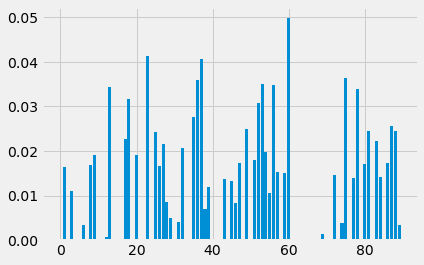

In [63]:
row = round(0.8 * broksum_vol_cumsum.shape[0])
    
#         data = std_scaler.fit_transform(data)
data_x = broksum_vol_cumsum.iloc[:,:-1]
data_y = broksum_vol_cumsum.iloc[:,-1]

print(data_y.shape)
# data_x = scaler.fit_transform(data_x)
# data_y = scaler_y.fit_transform(pd.DataFrame(data_y))

# data_x =
data = pd.concat([pd.DataFrame(data_x), pd.DataFrame(data_y)], axis=1, ignore_index=True)
# print(data)
# print(data_y)

# X_cls_train = data_x[:int(row)]
# X_cls_test = data_x[int(row):]
# y_cls_train = data_y[:int(row)]
# y_cls_test = data_y[int(row):]


# data = pd.DataFrame(data,columns = stock_df_selected.columns)
data_train = data[:int(row)]
data_test = data[int(row):]

# data.describe()
# data_x = data[:,:-1]
# data_y = data[:,-1]
X_cls_train, y_cls_train = split_multi_output(data_train, 1, 1)
X_cls_test, y_cls_test = split_multi_output(data_test, 1, 1)
X_cls_train = np.reshape(feature_train, (feature_train.shape[0], feature_train.shape[1]*feature_train.shape[2]))
X_cls_test = np.reshape(feature_test, (feature_test.shape[0], feature_test.shape[1]*feature_test.shape[2]))
# __train test split__
from sklearn.model_selection import train_test_split
# X_cls_train, X_cls_test, y_cls_train, y_cls_test = train_test_split(data_x, data_y, test_size=0.3, random_state=432, stratify=data_y)
# print(X_cls_train)
# print(y_cls_train)
print (X_cls_train.shape, label_train.shape)
print (X_cls_test.shape, label_test.shape)

#Create a Gaussian Classifier - incremental training - warm_start=True
model=RandomForestClassifier(n_estimators=1000, criterion='gini', max_depth=30, min_samples_leaf=10, n_jobs=-1, warm_start=True)
# model=RandomForestRegressor(n_estimators=500, random_state=0,  max_depth=30, min_samples_leaf=30, n_jobs=-1)

# __ACTUAL TRAINING __
model = model.fit(X_cls_train, label_train)
# clf

# __making accuracy report__
# ideally should be getting better with each round
y_cls_pred = model.predict(X_cls_test)

# inv_pred = scaler_y.inverse_transform(pd.DataFrame(y_cls_pred))
# inv_test = scaler_y.inverse_transform(pd.DataFrame(y_cls_test))

from sklearn.metrics import classification_report, r2_score
report = classification_report(label_test, y_cls_pred)
# report = r2_score(label_test, y_cls_pred)
# report2 = r2_score(inv_test, inv_pred)


print(report)
# print(report2)
importance = model.feature_importances_
# summarize feature importance
broker_top = []
for i,v in enumerate(importance):
    if v>0.03:
        broker_top.append(i)
        print('Feature: %0d, Score: %.5f' % (i,v))
    
print(importance)
print(broker_top)

# plot feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.show()

In [64]:
print(stock_df_selected.columns[broker_top])

Index(['BQ', 'CD', 'DH', 'HD', 'HP', 'MG', 'MI', 'NI', 'PD', 'SQ', 'TP'], dtype='object')


In [42]:
perm_importance = permutation_importance(model, X_cls_test, label_test, scoring='accuracy')
importance = perm_importance.importances_mean
# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.show()
# sorted_idx = perm_importance.importances_mean.argsort()
# plt.barh(boston.feature_names[sorted_idx], perm_importance.importances_mean[sorted_idx])
# plt.xlabel("Permutation Importance")


KeyboardInterrupt: 

In [125]:
# scores = model.evaluate(feature_test, label_test, verbose=0)
# print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
# save model and architecture to single file
model.save("model.h5")
print("Saved model to disk")

AttributeError: 'RandomForestClassifier' object has no attribute 'save'

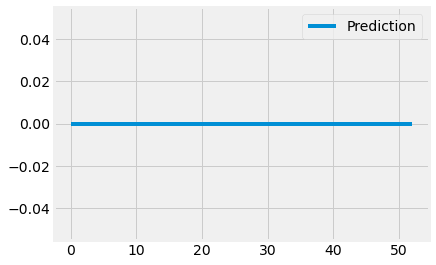

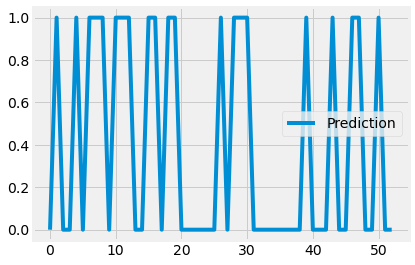

In [57]:
#Let's use the model and predict the stock
# predicted_stock_price = model.predict(feature_test)
# print(feature_test[-1::])
# print(predicted_stock_price)


# plot_results(inv_pred,y_cls_test)
# plot_results(inv_pred,inv_test)

plot_result(y_cls_pred)
plot_result(label_test)

In [ ]:
predictions = predict_sequences_multiple(model, feature_test, Enrol_window, 60)
plot_results_multiple(predictions, label_test, 100)  